In [1]:
#simulations infrastructure
import splat
import wisps.simulations as wispsim
from wisps.utils.tools import distance
from astropy.coordinates import SkyCoord

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import wisps
import pandas as pd

import seaborn as sns
%matplotlib inline
import splat.photometry as sphot
import splat.core as spl
import splat.empirical as spe
import matplotlib as mpl
from tqdm import tqdm

#matplotlib defaults
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['figure.figsize'] = [6.0, 3.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

from astropy import stats as astrostats

Aim: to integrate the number density of UCDs found and compare it to predictions <br>

$$ 
N_{pred}(SpT) = \Delta \Omega \times \Phi(SpT) \int _{l_{min}} ^{l_{max}}  F_s(SpT, r) \cdot \rho (r, z)l^2 dl
$$

## Visualize the luminosity function

In [2]:
#wispsim.make_luminosity_function()

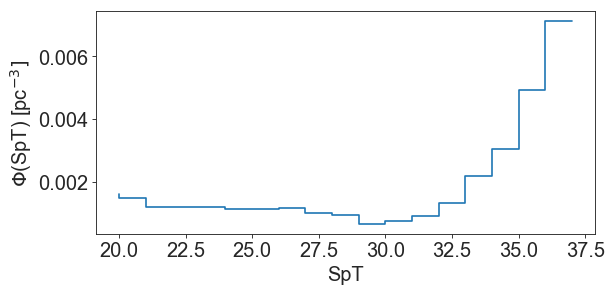

In [3]:
lf=wispsim.LUMINOSITY_FUCTION
sp_grid=np.arange(20, 38)
spts=[splat.typeToNum(x) for x in sp_grid] #spectral range
phi=wispsim.interpolate_luminosity(sp_grid)
cphi=np.cumsum(phi)  

fig, ax=plt.subplots(ncols=1, figsize=[8.0, 4.0])
ax.step(sp_grid, phi)


ax.set_ylabel(r'$\Phi$(SpT) [pc$^{-3}]$')
ax.set_xlabel(r'SpT')
plt.tight_layout()
#plt.savefig(wisps.OUTPUT_FIGURES+'/simulated_phi.pdf')

## Visualize the selection function

The selection function is a matrix of selected spectra per magnitude per spectral type

In [4]:
SF=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl').weight_function
#ds=np.logspace(-1, 4, 100)
#for s in sp_grid:
#    fx=SF( np.linspace(100, 3000, 100))
#    plt.plot(np.linspace(100, 3000, 100), fx, c='k')
#    plt.yticks(np.linspace(0, 1, 6))
#    plt.grid(_)
#    plt.xlabel('d (pc)')
#    plt.ylabel(r'< F$_s$ >')
#    plt.tight_layout()
#    plt.savefig(wisps.OUTPUT_FIGURES+'/selection_function.pdf')

In [5]:
SF

## Distance limits for each pointing

The selection function is a matrix of selected spectra per magnitude per spectral type

In [6]:
def get_pointing_name(grism_id):
    if grism_id.lower().startswith('par'):
        return grism_id.split('_BEAM_')[0]
    else:
        return grism_id.split('-G')[0]
obs=pd.read_csv(wisps.OUTPUT_FILES+'//observation_log_with_limit.csv')
cands=pd.read_csv(wisps.OUTPUT_FILES+'/candidates.csv')
cands['pointing']=cands.grism_id.apply(get_pointing_name)

In [7]:
#cands['pointing']

In [8]:
bmags={'F110W':obs.bright_F110W.values, 'F140W':obs.bright_F140W.values, 'F160W':obs.bright_F160W.values} #suppose each mag is a field
fmags={'F110W':obs.faint_F110W.values, 'F140W':obs.faint_F140W.values, 'F160W':obs.faint_F160W.values} 
#suppose I have a range of limiting magnitudes 
coords= SkyCoord(obs['ra (deg)'].values, obs['dec(deg)'].values, unit=u.deg)

area=(4.3*(u.arcmin**2)).to((u.radian)**2)

In [9]:
bmags=pd.DataFrame(bmags)
for k in bmags.columns: bmags[k]=18.0
fmags=pd.DataFrame(fmags)
for k in fmags.columns: fmags[k]=22.0

In [10]:
spts=[splat.typeToNum(x) for x in sp_grid]

In [11]:
result=[]
error_bars=[]
ds=[]
dserror=[]
res_w_slfx=[]

for spt in  tqdm(spts):
    distancesmax=distance(dict(fmags), spt)
    distancesmin=distance(dict(bmags), spt)
    

    
    mean_distmax=np.nanmean([distancesmax.distF110W, distancesmax.distF140W, distancesmax.distF160W], axis=0)
    std_distmax=np.nanstd([distancesmax.distF110W, distancesmax.distF140W, distancesmax.distF160W], axis=0)
    
    mean_distmin=np.nanmean([distancesmin.distF110W, distancesmin.distF140W, distancesmin.distF160W], axis=0)
    std_distmin=np.nanstd([distancesmin.distF110W, distancesmin.distF140W, distancesmin.distF160W], axis=0)
    
    derror=np.nanmedian([std_distmax, std_distmin], axis=0)
    
    #print (mean_distmin, mean_distmax, distancesmax)
    solid_angle=(np.sin(np.sqrt(area)))**2.0
    ds.append(mean_distmax-mean_distmin)
    dserror.append(derror)
      
    result.append([wispsim.number(c, d0, df, splat.typeToNum(spt), weight_function=SF)*solid_angle for c, d0, df in zip(coords, mean_distmin, mean_distmax)])
    error_bars.append([wispsim.number(c, 0, de, splat.typeToNum(spt), weight_function=SF)*solid_angle for c, de in zip(coords, derror)])
    res_w_slfx.append([wispsim.number(c, d0, df, splat.typeToNum(spt))*solid_angle for c, d0, df in zip(coords, mean_distmin, mean_distmax)])
    

100%|██████████| 18/18 [13:45<00:00, 45.33s/it]


In [12]:
result=abs(np.array(result))
errors=abs(np.array(error_bars))
wisp_o_sel=abs(np.array(res_w_slfx))

In [13]:
np.nanmedian(np.array(dserror))/np.nanmedian(np.array(ds))

0.21905879551663202

## Volume sampled for each spectral type

The selection function is a matrix of selected spectra per magnitude per spectral type

Text(0.5, 0, 'SpT')

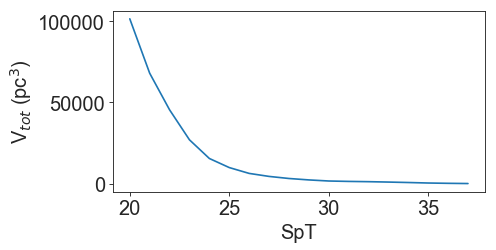

In [23]:
volumes=np.nansum([np.array(d)**3*0.3*solid_angle for d in ds], axis=1)
plt.plot(mdf.spt, volumes)
plt.ylabel(r'V$_{tot}$ (pc$^3$)')
plt.xlabel(r'SpT')

## Comparison to the observed numbers

The selection function is a matrix of selected spectra per magnitude per spectral type

In [15]:
pred_nbrs=np.nansum(result, axis=1)*phi
pred_w_selc=np.nansum(wisp_o_sel, axis=1)*phi
pred_errors=np.nansum(error_bars, axis=1)

In [16]:
cands=wisps.datasets['candidates']

In [17]:
cands['spt']=cands.spt.apply(splat.typeToNum)
#only look between 17 and 38, that's where the lfunction is defined
maskd=(cands[(cands.spt>=20)&(cands.spt<=38.0)]).spt
mdf=pd.DataFrame()
mdf['spt']=np.arange(20, 38)
mdf['number']=np.histogram(maskd.values, bins=18)[0]
mdf.to_pickle(wisps.OUTPUT_FILES+'/measured_lf.pickle')

In [18]:
#the and their cumulative distributions
pred_cm_numbers=np.cumsum(np.flip(pred_nbrs))
pred_cm_w_sel=np.cumsum(np.flip(pred_w_selc))
observed_cm_numbers=np.cumsum(np.flip(mdf.number.values))

pred_numbers=pred_nbrs

In [19]:
#plt.plot(pred_cm_numbers, pred_cm_w_sel)
#plt.plot(pred_cm_w_sel, pred_cm_w_sel)

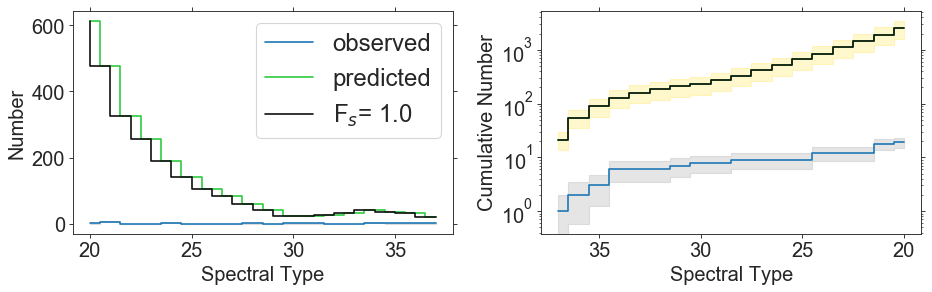

In [20]:
fig, ax=plt.subplots(ncols=2, figsize=(12, 4))
#plt.yscale('log')
ax[0].step(mdf.spt,mdf.number, label='observed', where='mid')
ax[0].step(mdf.spt, pred_numbers, label='predicted', where='mid', color='#2ECC40')
ax[0].step(mdf.spt,pred_w_selc, label=r'F$_s$= 1.0', color='#111111')

#ax[0].step(mdf.spt, pred_numbers*0.9, label='predicted*completeness', where='mid', color='#39CCCC')
poisson=astrostats.poisson_conf_interval(mdf.number, interval='root-n')

ax[0].fill_between(mdf.spt, poisson[0], poisson[1],
                 color='gray',step="mid", alpha=0.2)



ax[0].set_xlabel('Spectral Type')
ax[0].set_ylabel('Number')
#ax[0].grid()
#ax[0].legend()


ax[1].step(np.flip(mdf.spt.values),observed_cm_numbers, label='observed', where='mid')
ax[1].step(np.flip(mdf.spt.values), pred_cm_numbers, label='predicted/100', where='mid', color='#2ECC40')
ax[1].step(np.flip(mdf.spt.values),pred_cm_w_sel , label=r'F$_s$= 1.0', where='mid',  color='#111111')

ax[1].fill_between(np.flip(mdf.spt.values), pred_cm_numbers+ pred_cm_numbers*0.37,  pred_cm_numbers- pred_cm_numbers*0.37,
                 color='#FFDC00',step="mid", alpha=0.2)

#ax[1].fill_between(np.flip(mdf.spt.values), pred_cm_numbers+ pred_cm_numbers*3.0*0.37,  pred_cm_numbers- pred_cm_numbers*3.0*0.37,
#                 color='#FFDC00',step="mid", alpha=0.1)

poissonc=astrostats.poisson_conf_interval(observed_cm_numbers, interval='root-n')

ax[1].fill_between(np.flip(mdf.spt.values), poissonc[0],  poissonc[1],
                 color='gray',step="mid", alpha=0.2)

ax[1].yaxis.set_ticks_position('both')
ax[1].xaxis.set_ticks_position('both')
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')

ax[1].set_xlabel('Spectral Type')
ax[1].set_ylabel('Cumulative Number')
#ax[1].grid()
ax[1].invert_xaxis()

#ax[0].set_yscale('log')
ax[1].set_yscale('log')

#ax[1].grid()
#ax[0].grid()
ax[0].legend()
plt.tight_layout()
#plt.savefig(wisps.OUTPUT_FIGURES+'/oberved_numbers.pdf')

In [21]:
len(coords)

533